# Test

### Julien Pelegri (@algoquant on TG)

#### Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

(1,15): error CS1002: ; expected
(1,15): error CS1525: Invalid expression term 'as'
(1,20): error CS1002: ; expected
(2,14): error CS1002: ; expected
(2,14): error CS1525: Invalid expression term 'as'
(2,19): error CS1002: ; expected
(3,26): error CS1003: Syntax error, '(' expected
(3,26): error CS1041: Identifier expected; 'as' is a keyword
(4,6): error CS1003: Syntax error, ',' expected
(4,22): error CS1003: Syntax error, ',' expected
(4,30): error CS1001: Identifier expected
(4,30): error CS1026: ) expected
(4,30): error CS1002: ; expected

In [1]:
#!ls -l

# To run it put the .xlsx 

In [1]:
data = pd.read_excel('btc-perp.xlsx', sheet_name='in')
data.head()

,UtcUnixTimeInMilliSeconds,Close,Volume
0,1605250800000,16325.5,16.371507
1,1605250860000,16325.0,1.078070
2,1605250920000,16328.5,27.859270
3,1605250980000,16323.0,2.309463
4,1605251040000,16322.0,2.565759


### Time processing

#### I don't like this 'UtcUnixTimeInMilliSeconds' : let's convert it to something more readable 

In [1]:
data['UtcUnixTime'] = data['UtcUnixTimeInMilliSeconds']/1000

time = []
for i in range(len(data.Close)): 
    
    time.append(datetime.utcfromtimestamp(data.UtcUnixTime[i]).strftime('%Y-%m-%d %H:%M:%S'))
    
data['time'] = time
data.head(2)

,UtcUnixTimeInMilliSeconds,Close,Volume,UtcUnixTime,time
0,1605250800000,16325.5,16.371507,1.605251e+09,2020-11-13 07:00:00
1,1605250860000,16325.0,1.078070,1.605251e+09,2020-11-13 07:01:00


In [1]:
data['step'] = [i for i in range(len(data.Close))]

data.shape

(129361, 6)

I don't konw much on options so I am doing some researchs...

## Some plotting

In [1]:
## 20 period moving average on 15m candle
data['EMA'] = pd.to_numeric(data["Close"], downcast="float").ewm(span=20*60*15,adjust=False).mean()
data['SMA'] = pd.to_numeric(data["Close"], downcast="float").rolling(window=20*60*15).mean()

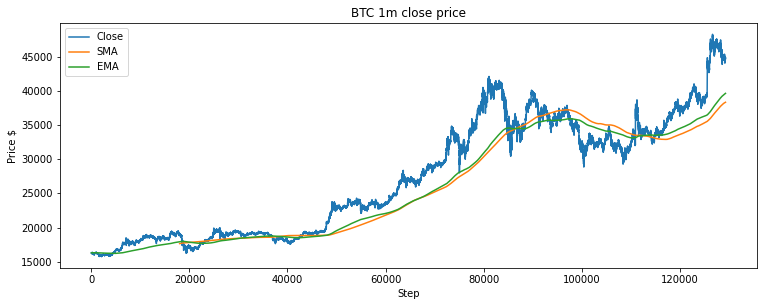

In [1]:
plt.figure(figsize=(12.5, 4.5))
plt.plot(data["step"], data['Close'], label='Close', linewidth=1.5)
plt.plot(data["step"], data['SMA'], label='SMA', linewidth=1.5)
plt.plot(data["step"], data['EMA'], label='EMA', linewidth=1.5)

plt.title("BTC 1m close price")
plt.xlabel('Step')
plt.ylabel('Price $')
plt.legend(loc = 'upper left')
plt.show()

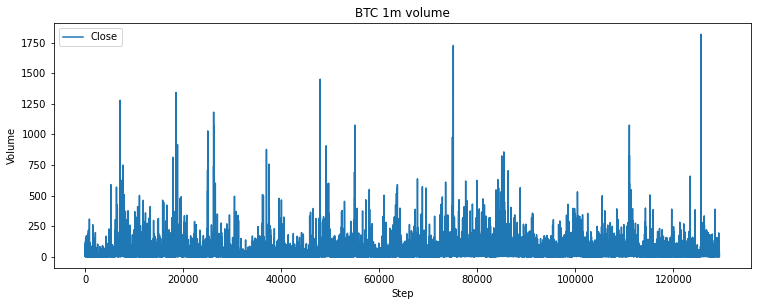

In [1]:
plt.figure(figsize=(12.5, 4.5))
plt.plot(data["step"], data['Volume'], label='Close', linewidth=1.5)

plt.title("BTC 1m volume")
plt.xlabel('Step')
plt.ylabel('Volume')
plt.legend(loc = 'upper left')
plt.show()

## The PNL 

 - Formula : P&L1->2 = 50 * $Γ * (ΔS / S1)^2 where ΔS = S2 – S1
    - Plus some conditions (easy to understand)
    
&nbsp;

 - So : constant * another fixed constant * ((delta price between two steps)/ Price step 1)^^2)
 
&nbsp;

 - $Γ / $Θ / number of days for maturity: are three parameters
 
&nbsp;

 - Every seems clear to me except two points : 
    - the maturity concept : 
    ** Final Payoff: Sum of P&Li->j minus (Nb of days to maturity x $Θ)**
    
    - reset at any time, by default it is 1m but could it be 5m ? i don't think it's a parameter seems to be fixed at 1m

## Compute P&L i-> j (step of 1m)

#### Thought ? When a day reset h = 0 , m = 0 , s = 0 --> compute the pseudo maturation

In [1]:
print(data.time[49980][11:], data.time[49980][11:] == '00:00:00')

00:00:00 True

In [1]:
def PNL(data, gamma, theta):
    '''
    data : the data of close for each 1m candle
    gamma : given by the exercise (don't know the scale)
    theta : given by the exercise (don't know the scale)
    days_to_maturity : in days
    
    explanation : I decided to reset the S(i) value each 1m (logic to be according to the test)
    '''
    
    n = len(data.Close)
    
    # attributing first value to nan to dump it latter on
    pnl = [float("NaN")]
    
    for i in range(n-1):
        
        # if we are at the beginning of the day we  have to pay a fee 
        if (data.time[i+1][11:] == '00:00:00'):
            pnl.append(50*gamma*((data['Close'][i+1]-data['Close'][i])/data['Close'][i]) - theta)
        else:
            pnl.append(50*gamma*(((data['Close'][i+1]-data['Close'][i])/data['Close'][i]))**2)
            
            
    data['PNL'] = pnl
    return(data)

In [1]:
## Compute with specific value for the test since I have no idea of the kind of values it might be 

gamma = 1825000
theta = -250000
days_to_maturity = 30
data = data

data_PNL = PNL(data, gamma, theta)

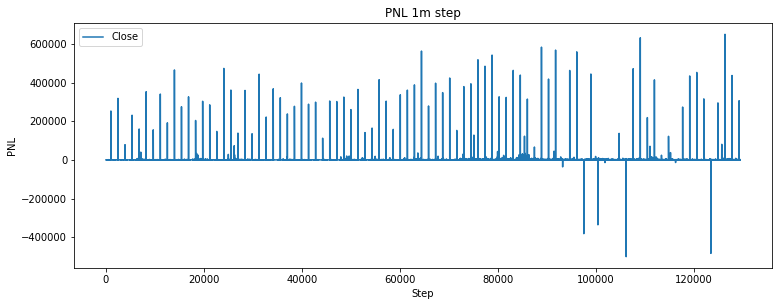

In [1]:
plt.figure(figsize=(12.5, 4.5))
plt.plot(data_PNL["step"], data_PNL['PNL'], label='Close', linewidth=1.5)

plt.title("PNL 1m step")
plt.xlabel('Step')
plt.ylabel('PNL')
plt.legend(loc = 'upper left')
plt.show()

#### This graph seems ok (distribution)

## Sum of cumulative PNL i->j

In [1]:
## dropping the first nan value
data_PNL.dropna(inplace=True)
data_PNL.reset_index(inplace=True)
data_PNL.tail()

,index,UtcUnixTimeInMilliSeconds,Close,Volume,UtcUnixTime,time,step,EMA,SMA,PNL
111357,129356,1613012160000,44801.5,20.977601,1.613012e+09,2021-02-11 02:56:00,129356,39626.371342,38328.538444,39.511185
111358,129357,1613012220000,44803.0,2.648302,1.613012e+09,2021-02-11 02:57:00,129357,39626.946491,38328.957056,0.102289
111359,129358,1613012280000,44861.5,4.639193,1.613012e+09,2021-02-11 02:58:00,129358,39627.528075,38329.378611,155.571635
111360,129359,1613012340000,44829.0,0.518052,1.613012e+09,2021-02-11 02:59:00,129359,39628.105985,38329.802972,47.890791
111361,129360,1613012400000,44775.0,3.355878,1.613012e+09,2021-02-11 03:00:00,129360,39628.677830,38330.212694,132.404361


In [1]:
data_PNL.PNL[0]

45.64117384837682

### The idea is to do a comulative sum minus this pseudo maturity 

In [1]:
def Cumulative_PNL(data_PNL, theta, days_to_maturity):
    cumulative_sum = [data_PNL.PNL[0]]
    
    for i in range(1, len(data_PNL.time)):
        
        # (1)
        #cumulative_sum.append(data_PNL.PNL[i] + cumulative_sum[i-1] - (days_to_maturity- (int(data_PNL.time[i][8:10]))*theta))
        
        # (2)
        cumulative_sum.append(data_PNL.PNL[i] + cumulative_sum[i-1])
    
    for i in range(len(data_PNL.time)):
        cumulative_sum[i] = cumulative_sum[i] - (days_to_maturity- (int(data_PNL.time[i][8:10]))*theta)
        
    data_PNL['cumulative_PNL'] = cumulative_sum
    return(data_PNL)

#### I missunderstood something here concerning this : 6. Final Payoff: Sum of P&Li->j minus (Nb of days to maturity x $Θ)



If if do it befoe the cumulative so for each step such as bellow '(1)' method I have something absurd

If i do it like the (2) so cumulative and then minus the maturity * theta i have something less absurd but tough to say if relevant since i don't understand the strategy...

In [1]:
data_cumu_PNL = Cumulative_PNL(data_PNL, theta, days_to_maturity)

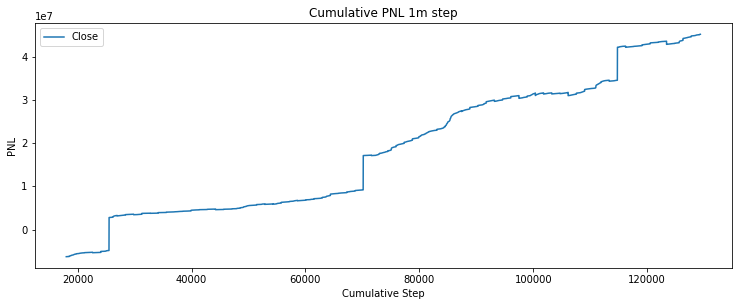

In [1]:
plt.figure(figsize=(12.5, 4.5))
plt.plot(data_cumu_PNL["step"], data_cumu_PNL['cumulative_PNL'], label='Close', linewidth=1.5)

plt.title("Cumulative PNL 1m step")
plt.xlabel('Cumulative Step')
plt.ylabel('PNL')
plt.legend(loc = 'upper left')
plt.show()

 - For me this result is not relevant and intersting, I might have not understood the "6. Final Payoff: Sum of P&Li->j minus (Nb of days to maturity x $Θ)"
concept; I cannot predict ,nothing with that : PNL almost always up ....

 - The PNL i->j looks good to me but I might have make a mistake also there 
 
 - I have tried other steps for reseting S(i) : the result seems way random 

## Data analysis : I will focus on PNL i->j to make a small ML model to have something to shocase

In [1]:
data_cumu_PNL.head(2)

,index,UtcUnixTimeInMilliSeconds,Close,Volume,UtcUnixTime,time,step,EMA,SMA,PNL,cumulative_PNL
0,17999,1606330740000,19075.0,6.611942,1.606331e+09,2020-11-25 18:59:00,17999,17951.576787,17664.848722,45.641174,-6.249984e+06
1,18000,1606330800000,19093.0,5.548899,1.606331e+09,2020-11-25 19:00:00,18000,17951.703604,17665.002472,81.254756,-6.249903e+06


In [1]:
data_cumu_PNL[['Close', 'Volume', 'cumulative_PNL', 'PNL']].describe()

,Close,Volume,cumulative_PNL,PNL
count,111362.000000,111362.000000,1.113620e+05,111362.000000
mean,28959.607142,22.802495,1.841018e+07,430.093645
std,8115.224219,43.280356,1.516046e+07,9611.803321
min,16237.500000,0.000000,-6.249984e+06,-500569.273189
25%,19440.500000,3.626781,4.740122e+06,7.213653
50%,30886.750000,10.059960,1.781777e+07,41.652433
75%,35450.000000,24.879812,3.127672e+07,165.419965
max,48266.000000,1818.078071,4.514606e+07,649345.691889


In [1]:
data_cumu_PNL[['Close', 'Volume', 'cumulative_PNL', 'PNL']].corr()

,Close,Volume,cumulative_PNL,PNL
Close,1.000000,0.075333,0.901097,0.010637
Volume,0.075333,1.000000,0.036893,0.058802
cumulative_PNL,0.901097,0.036893,1.000000,0.005669
PNL,0.010637,0.058802,0.005669,1.000000


In [1]:
data_cumu_PNL[['Close', 'Volume', 'cumulative_PNL', 'PNL']].skew()

Close              0.063880
Volume             8.704280
cumulative_PNL     0.211649
PNL               37.980539
dtype: float64

## Ok let's invent a fake 'ML' problem based on PNL i->j 

- What to predict : let's say we have fees so we want to do the pseudo trade when the PNL i->j is > 50$ (for fees issue right?)

In [1]:
output = []

for i in range(len(data_cumu_PNL)):
    if data_cumu_PNL.PNL[i]>50:
        output.append(1)
        
    else : 
        output.append(0)
    
data_cumu_PNL['output'] = output        

In [1]:
data_cumu_PNL.output.value_counts()

0    59314
1    52048
Name: output, dtype: int64

My idea : 
    - classification problem (up or down)
    - inputs : 
        - volume (std scale)
        - add moving average (above bellow labelled 0 and 1)
        - compute volatility and scale it on x periods
        - try other indicator for sure well processed
    - model : grid seach on a SVC more chance to have this model work (seems to be non linear)
    - split train / test : draw first conclusions

## the end